# Transfer Learning to detect cats / dogs using Vgg16

## Definitions

Re-run this cell when starting from a checkpoint

In [25]:
#reset python environment
%reset -f

import time

default_device = '/gpu:0'
# default_device = '/cpu:0'

num_hidden_neurons = 256

vgg_mean = [103.939, 116.779, 123.68]
classes = [l.strip() for l in open('synset.txt').readlines()]

training_dataset_dir = './datasets/dogs-vs-cats-redux-kernels-edition/train/'
test_dataset_dir = './datasets/dogs-vs-cats-redux-kernels-edition/test/'

#model_version = int(time.time())
model_version = 3
model_path = 'models/model-{}/'.format(model_version)

def get_batches(x, y, batch_size=32):
    num_rows = y.shape[0]
    
    num_batches = num_rows // batch_size
    
    if num_rows % batch_size != 0:
        num_batches = num_batches + 1

    for batch in range(num_batches):
        yield x[batch_size * batch: batch_size * (batch + 1)], y[batch_size * batch: batch_size * (batch + 1)]

## Vgg16 Model Class

In [ ]:
import tensorflow as tf

class Vgg16Model:
    def __init__(self, weights_path='./vgg16.npy'):
        self.weights = np.load('vgg16.npy', encoding='latin1').item()
        self.activation_fn = tf.nn.relu
        self.conv_padding = 'SAME'
        self.pool_padding = 'SAME'
        self.use_bias = True

    def build(self, input_tensor, trainable=False):
        self.conv1_1 = self.conv2d(input_tensor, 'conv1_1', 64, trainable)
        self.conv1_2 = self.conv2d(self.conv1_1, 'conv1_2', 64, trainable)

        # Max-pooling is performed over a 2 × 2 pixel window, with stride 2.
        self.max_pool1 = tf.layers.max_pooling2d(self.conv1_2, (2, 2), (2, 2), padding=self.pool_padding)

        self.conv2_1 = self.conv2d(self.max_pool1, 'conv2_1', 128, trainable)
        self.conv2_2 = self.conv2d(self.conv2_1, 'conv2_2', 128, trainable)

        self.max_pool2 = tf.layers.max_pooling2d(self.conv2_2, (2, 2), (2, 2), padding=self.pool_padding)

        self.conv3_1 = self.conv2d(self.max_pool2, 'conv3_1', 256, trainable)
        self.conv3_2 = self.conv2d(self.conv3_1, 'conv3_2', 256, trainable)
        self.conv3_3 = self.conv2d(self.conv3_2, 'conv3_3', 256, trainable)

        self.max_pool3 = tf.layers.max_pooling2d(self.conv3_3, (2, 2), (2, 2), padding=self.pool_padding)

        self.conv4_1 = self.conv2d(self.max_pool3, 'conv4_1', 512, trainable)
        self.conv4_2 = self.conv2d(self.conv4_1, 'conv4_2', 512, trainable)
        self.conv4_3 = self.conv2d(self.conv4_2, 'conv4_3', 512, trainable)

        self.max_pool4 = tf.layers.max_pooling2d(self.conv4_3, (2, 2), (2, 2), padding=self.pool_padding)

        self.conv5_1 = self.conv2d(self.max_pool4, 'conv5_1', 512, trainable)
        self.conv5_2 = self.conv2d(self.conv5_1, 'conv5_2', 512, trainable)
        self.conv5_3 = self.conv2d(self.conv5_2, 'conv5_3', 512, trainable)

        self.max_pool5 = tf.layers.max_pooling2d(self.conv5_3, (2, 2), (2, 2), padding=self.pool_padding)

        reshaped = tf.reshape(self.max_pool5, shape=(-1, 7 * 7 * 512))

        self.fc6 = self.fc(reshaped, 'fc6', 4096, trainable)
        self.fc7 = self.fc(self.fc6, 'fc7', 4096, trainable)

        self.fc8 = self.fc(self.fc7, 'fc8', 1000, trainable)

        self.predictions = tf.nn.softmax(self.fc8, name='predictions')

    def conv2d(self, layer, name, n_filters, trainable, k_size=3):
        return tf.layers.conv2d(layer, n_filters, kernel_size=(k_size, k_size),
                                activation=self.activation_fn, padding=self.conv_padding, name=name, trainable=trainable,
                                kernel_initializer=tf.constant_initializer(self.weights[name][0], dtype=tf.float32),
                                bias_initializer=tf.constant_initializer(self.weights[name][1], dtype=tf.float32),
                                use_bias=self.use_bias)

    def fc(self, layer, name, size, trainable):
        return tf.layers.dense(layer, size, activation=self.activation_fn,
                               name=name, trainable=trainable,
                               kernel_initializer=tf.constant_initializer(self.weights[name][0], dtype=tf.float32),
                               bias_initializer=tf.constant_initializer(self.weights[name][1], dtype=tf.float32),
                               use_bias=self.use_bias)

## Images conversion for Vgg16

Images have to be of dimension (224, 224, 3). The last dimension is ordered BGR (blue, green, red)

In [ ]:
import skimage
import skimage.io
import skimage.transform

# https://github.com/machrisaa/tensorflow-vgg/blob/master/utils.py
def load_image(image_path, mean=vgg_mean):
    image = skimage.io.imread(image_path)

    image = image.astype(float)
    
    short_edge = min(image.shape[:2])
    yy = int((image.shape[0] - short_edge) / 2)
    xx = int((image.shape[1] - short_edge) / 2)
    crop_image = image[yy: yy + short_edge, xx: xx + short_edge]
    
    resized_image = skimage.transform.resize(crop_image, (224, 224), mode='constant') 
            
    bgr = resized_image[:,:,::-1] - mean
    
    return bgr

## Extract Vgg16 features

In [ ]:
import time
import os
import math

def extract_codes(image_directory, batch_size=32):
    tf.reset_default_graph()

    # create mapping of filename -> vgg features
    codes_fc6 = {}
    codes_fc7 = {}
    predictions = {}

    filenames = os.listdir(image_directory)
    num_files = len(filenames)
    num_batches = int(math.ceil(num_files / batch_size))
    
    with tf.device(default_device):
        with tf.Session(graph = tf.Graph()) as sess:    
            _input = tf.placeholder(tf.float32, shape=(None, 224, 224, 3), name="images")

            vgg = Vgg16Model()
            vgg.build(_input)

            sess.run(tf.global_variables_initializer())

            for i in range(num_batches):
                batch_filenames = filenames[i*batch_size : ((i+1)*batch_size)]

                print("batch {} of {}".format(i+1, num_batches))

                start = time.time()
                images = np.array([load_image(image_directory + f) for f in batch_filenames])
                end = time.time()
                print("\timage loading took {:.4f} sec".format(end-start))

                start = end

                batch_codes_fc6, batch_codes_fc7 = sess.run(
                    [vgg.fc6, vgg.fc7],
                    feed_dict={ _input: images }
                )

                end = time.time()
                print("\tprediction took {:.4f} sec".format(end-start))

                for i, filename in enumerate(batch_filenames):
                    codes_fc6[filename] = batch_codes_fc6[i]
                    codes_fc7[filename] = batch_codes_fc7[i]

            return codes_fc6, codes_fc7

In [ ]:
import numpy as np

print('Extracting training codes for fc6 and fc7')
training_codes_fc6, training_codes_fc7 = extract_codes(training_dataset_dir)
np.save('training_codes_fc6.npy', training_codes_fc6)
np.save('training_codes_fc7.npy', training_codes_fc7)

print('Extracting test codes for fc6 and fc7')
test_codes_fc6, test_codes_fc7 = extract_codes(test_dataset_dir, batch_size=16)
np.save('test_codes_fc6.npy', test_codes_fc6)
np.save('test_codes_fc7.npy', test_codes_fc7)

## Checkpoint - Vgg16 features extracted and serialized

In [26]:
import numpy as np
import tensorflow as tf

## Load previously stored training codes (fc6)

In [27]:
from collections import OrderedDict
training_codes = np.load('training_codes_fc6.npy')
training_codes = OrderedDict(training_codes.item())

## Preprocess training data

In [28]:
keys = list(training_codes.keys())

labels = np.array([ (1, 0) if name[:3] == 'dog' else (0,1) for name in keys]) # one hot encode labels

images = np.array(list(training_codes.values())) # extract images

for i,key in enumerate(keys):
    assert (training_codes.get(key) == images[i]).all()

## Split into training and validation set

In [29]:
from sklearn.model_selection import StratifiedShuffleSplit
    
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.1)
train_indices, val_indices = next(splitter.split(images, labels))

train_images, train_labels = images[train_indices], labels[train_indices]
val_images, val_labels = images[val_indices], labels[val_indices]

## Transfer Learning Step - Use a small NN with a single hidden layer

In [11]:
import os
import time

from tensorflow.python.saved_model import builder as saved_model_builder
from tensorflow.python.saved_model.signature_def_utils import predict_signature_def

from tensorflow.python.saved_model.tag_constants import SERVING
from tensorflow.python.saved_model.signature_constants import DEFAULT_SERVING_SIGNATURE_DEF_KEY
from tensorflow.python.saved_model.signature_constants import PREDICT_INPUTS
from tensorflow.python.saved_model.signature_constants import PREDICT_OUTPUTS
            
if(os.path.exists(model_path)):
    raise Exception('directory "{}" already exists. Delete or move it'.format(model_path))

num_epochs = 5
learning_rate = 0.01
keep_prob = 0.5
batch_size = 64
accuracy_print_steps = 10
iteration = 0

tf.reset_default_graph()

with tf.device(default_device):
    with tf.Session(graph=tf.Graph()) as sess:
        
        with tf.name_scope("inputs"):
            _images = tf.placeholder(tf.float32, shape=(None, 4096), name='images')
            _keep_prob = tf.placeholder(tf.float32, name='keep_probability')

        with tf.name_scope("targets"):
            _labels = tf.placeholder(tf.float32, shape=(None, 2), name='labels')
            
        with tf.name_scope("hidden_layer"):
            hidden_weights = tf.Variable(
                initial_value = tf.truncated_normal([4096, num_hidden_neurons], mean=0.0, stddev=0.01),
                dtype=tf.float32, name="hidden_weights"
            )
            
            hidden_bias = tf.Variable(
                initial_value = tf.zeros(num_hidden_neurons), 
                dtype=tf.float32,
                name="hidden_bias"
            )
            
            hidden = tf.matmul(_images, hidden_weights) + hidden_bias
            hidden = tf.nn.relu(hidden, name="hidden_relu")
            hidden = tf.nn.dropout(hidden, keep_prob=_keep_prob, name='hidden_dropout')
            
            tf.summary.histogram("hidden_weights", hidden_weights)
            tf.summary.histogram("hidden_bias", hidden_bias)

            
        with tf.name_scope("outputs"):
            output_weights = tf.Variable(
                initial_value=tf.truncated_normal(shape=(num_hidden_neurons, 2), mean=0.0, stddev=0.01),
                dtype=tf.float32, name="output_weights"
            )
            
            output_bias = tf.Variable(initial_value=tf.zeros(2), dtype=tf.float32, name="output_bias")
            
            logits = tf.matmul(hidden, output_weights) + output_bias
            predictions = tf.nn.softmax(logits, name='predictions')
            
            tf.summary.histogram("output_weights", output_weights)
            tf.summary.histogram("output_bias", output_bias)
            tf.summary.histogram("predictions", predictions)
    
        with tf.name_scope("cost"):
            cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=_labels, name='cross_entropy')
            cost = tf.reduce_mean(cross_entropy, name='cost')
            
            tf.summary.scalar("cost", cost)

        with tf.name_scope("train"):
            optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
            correct_predictions = tf.equal(tf.argmax(predictions, 1), tf.argmax(_labels, 1), name='correct_predictions')
            accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32), name='accuracy')

        ### merge summaries
        merged_summaries = tf.summary.merge_all()
        
        ###  Save training and validation logs for tensorboard
        train_writer = tf.summary.FileWriter('./logs/train/{}'.format(model_version), sess.graph)
        val_writer = tf.summary.FileWriter('./logs/val/{}'.format(model_version))
        
        sess.run(tf.global_variables_initializer())

        for epoch in range(num_epochs):
            for batch_train_images, batch_train_labels in get_batches(train_images, train_labels, batch_size=batch_size):
                train_loss, _, p, summary = sess.run(
                    [cost, optimizer, logits, merged_summaries], 
                    feed_dict = { 
                        _images: batch_train_images,
                        _labels: batch_train_labels,
                        _keep_prob: keep_prob
                    })

                train_writer.add_summary(summary, iteration)
                
                iteration = iteration + 1

                if iteration % accuracy_print_steps == 0:
                    val_acc, val_summary = sess.run([accuracy, merged_summaries], feed_dict ={
                        _images: val_images,
                        _labels: val_labels,
                        _keep_prob: 1.
                    })

                    val_writer.add_summary(val_summary, iteration)
                    print('{} / {} Accuracy: {} Loss: {}'.format(epoch + 1, num_epochs, val_acc, train_loss))
        
                

        
        ### Save graph and trained variables
        builder = saved_model_builder.SavedModelBuilder(model_path)

        builder.add_meta_graph_and_variables(
            sess, [SERVING],
            signature_def_map = {
                DEFAULT_SERVING_SIGNATURE_DEF_KEY: predict_signature_def(
                    inputs = { PREDICT_INPUTS: _images },
                    outputs = { PREDICT_OUTPUTS: predictions }
                )
            }
        )

        builder.save()

1 / 5 Accuracy: 0.9811999797821045 Loss: 1.371485710144043
1 / 5 Accuracy: 0.9876000285148621 Loss: 1.008857250213623
1 / 5 Accuracy: 0.9687999486923218 Loss: 2.255924701690674
1 / 5 Accuracy: 0.9871999621391296 Loss: 1.1175867342672063e-08
1 / 5 Accuracy: 0.986799955368042 Loss: 1.4236068725585938
1 / 5 Accuracy: 0.981999933719635 Loss: 0.8758718371391296
1 / 5 Accuracy: 0.9871999621391296 Loss: 2.2606959342956543
1 / 5 Accuracy: 0.9839999079704285 Loss: 0.7830793261528015
1 / 5 Accuracy: 0.9747999310493469 Loss: 0.551234245300293
1 / 5 Accuracy: 0.9875999093055725 Loss: 0.0
1 / 5 Accuracy: 0.9875999689102173 Loss: 0.15216828882694244
1 / 5 Accuracy: 0.9871999621391296 Loss: 0.1553376019001007
1 / 5 Accuracy: 0.986799955368042 Loss: 1.0859946012496948
1 / 5 Accuracy: 0.985599935054779 Loss: 0.0
1 / 5 Accuracy: 0.9824000000953674 Loss: 0.05088839307427406
1 / 5 Accuracy: 0.9864000082015991 Loss: 0.04488513618707657
1 / 5 Accuracy: 0.9860000014305115 Loss: 0.03164377063512802
1 / 5 Accu

# Interlude -  Try to find optimal hyperparameters

Run training with different hyperparameters and use tensorboard to investigate the best solution

In [30]:
import os
import time
import math

from tensorflow.python.saved_model import builder as saved_model_builder
from tensorflow.python.saved_model.signature_def_utils import predict_signature_def

from tensorflow.python.saved_model.tag_constants import SERVING
from tensorflow.python.saved_model.signature_constants import DEFAULT_SERVING_SIGNATURE_DEF_KEY
from tensorflow.python.saved_model.signature_constants import PREDICT_INPUTS
from tensorflow.python.saved_model.signature_constants import PREDICT_OUTPUTS

accuracy_print_steps = 100

def train(writer, num_epochs, hidden_layer_size, learning_rate, num_hidden=1, keep_prob=0.5, batch_size=64, training=True, saved_model_path=None):
    with tf.device(default_device):
        with tf.Session(graph=tf.Graph()) as sess:

            with tf.name_scope("inputs"):
                _images = tf.placeholder(tf.float32, shape=(None, 4096), name='images')
                _is_training = tf.placeholder(tf.bool, name='is_training')
                _keep_prob = tf.placeholder(tf.float32, name='keep_probability')

            with tf.name_scope("targets"):
                _labels = tf.placeholder(tf.float32, shape=(None, 2), name='labels')

            prev_size = 4096
            next_input = _images
            
            for i in range(num_hidden):
                with tf.variable_scope("hidden_layer_{}".format(i)):
                    hidden_weights = tf.Variable(
                        initial_value = tf.truncated_normal([prev_size, hidden_layer_size], mean=0.0, stddev=0.01),
                        dtype=tf.float32, name="hidden_weights"
                    )

                    hidden_bias = tf.Variable(
                        initial_value = tf.zeros(hidden_layer_size), 
                        dtype=tf.float32,
                        name="hidden_bias"
                    )

                    hidden = tf.matmul(next_input, hidden_weights) + hidden_bias
                    hidden = tf.layers.batch_normalization(hidden, training=_is_training)
                    hidden = tf.nn.relu(hidden, name="hidden_relu")
                    hidden = tf.nn.dropout(hidden, keep_prob=_keep_prob, name='hidden_dropout')

                    tf.summary.histogram("hidden_weights_{}".format(i), hidden_weights)
                    tf.summary.histogram("hidden_bias_{}".format(i), hidden_bias)
                    
                    next_input = hidden
                    prev_size = hidden_layer_size


            with tf.name_scope("outputs"):
                output_weights = tf.Variable(
                    initial_value=tf.truncated_normal(shape=(hidden_layer_size, 2), mean=0.0, stddev=0.01),
                    dtype=tf.float32, name="output_weights"
                )

                output_bias = tf.Variable(initial_value=tf.zeros(2), dtype=tf.float32, name="output_bias")

                logits = tf.matmul(next_input, output_weights) + output_bias
                predictions = tf.nn.softmax(logits, name='predictions')

                tf.summary.histogram("output_weights", output_weights)
                tf.summary.histogram("output_bias", output_bias)
                tf.summary.histogram("predictions", predictions)

            with tf.name_scope("cost"):
                cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=_labels, name='cross_entropy')
                cost = tf.reduce_mean(cross_entropy, name='cost')

                tf.summary.scalar("cost", cost)

            with tf.name_scope("train"):
                with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):                
                    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
                    correct_predictions = tf.equal(tf.argmax(predictions, 1), tf.argmax(_labels, 1), name='correct_predictions')
                    accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32), name='accuracy')

            ### merge summaries
            merged_summaries = tf.summary.merge_all()

            sess.run(tf.global_variables_initializer())
            
            iteration = 0
            for epoch in range(num_epochs):                
                for batch_train_images, batch_train_labels in get_batches(train_images, train_labels, batch_size=batch_size):
                    train_loss, _, p, summary = sess.run(
                        [cost, optimizer, logits, merged_summaries], 
                        feed_dict = { 
                            _images: batch_train_images,
                            _labels: batch_train_labels,
                            _keep_prob: keep_prob,
                            _is_training: training
                        })

                    iteration = iteration + 1

                    if iteration % accuracy_print_steps == 0:
                        if not writer == None:
                            writer.add_summary(summary, iteration)

                        if iteration % accuracy_print_steps == 0:
                            val_acc, val_summary = sess.run([accuracy, merged_summaries], feed_dict ={
                                _images: val_images,
                                _labels: val_labels,
                                _keep_prob: 1.,
                                _is_training: False
                            })


                            print('\tEpoch {}/{} Iteration {} Accuracy: {} Loss: {}'.format(epoch + 1, num_epochs, iteration, val_acc, train_loss))
            
            if not saved_model_path == None:
                ### Save graph and trained variables
                builder = saved_model_builder.SavedModelBuilder(saved_model_path)

                builder.add_meta_graph_and_variables(
                    sess, [SERVING],
                    signature_def_map = {
                        DEFAULT_SERVING_SIGNATURE_DEF_KEY: predict_signature_def(
                            inputs = { PREDICT_INPUTS: _images },
                            outputs = { PREDICT_OUTPUTS: predictions }
                        )
                    }
                )

                builder.save()


In [17]:
batch_size = 64

for num_epochs in [1, 5]:
    for keep_prob in [0.5, 0.8, 1.0]:
        for num_hidden_layers in [1, 2]:
            for hidden_layer_size in [512, 1024, 2048]:
                for learning_rate in [0.01, 0.001]:
                    log_string = 'logs/{}/e={},lr={},hl={},hs={},kp={},bs={}'.format(model_version, num_epochs, learning_rate, num_hidden_layers, hidden_layer_size, keep_prob, batch_size)
                    writer = tf.summary.FileWriter(log_string)

                    print("\n\nStarting {}".format(log_string))
                    train(writer, num_epochs, hidden_layer_size, learning_rate, num_hidden_layers, keep_prob, batch_size)



Starting logs/3/e=1,lr=0.01,hl=1,hs=512,kp=0.5,bs=64
	Epoch 1/1 Iteration 100 Accuracy: 0.9896000027656555 Loss: 0.018358992412686348
	Epoch 1/1 Iteration 200 Accuracy: 0.9920000433921814 Loss: 0.053292181342840195
	Epoch 1/1 Iteration 300 Accuracy: 0.9923999905586243 Loss: 0.040763720870018005


Starting logs/3/e=1,lr=0.001,hl=1,hs=512,kp=0.5,bs=64
	Epoch 1/1 Iteration 100 Accuracy: 0.9891999959945679 Loss: 0.016395797953009605
	Epoch 1/1 Iteration 200 Accuracy: 0.9879999756813049 Loss: 0.03796821087598801
	Epoch 1/1 Iteration 300 Accuracy: 0.9923999905586243 Loss: 0.007937289774417877


Starting logs/3/e=1,lr=0.01,hl=1,hs=1024,kp=0.5,bs=64
	Epoch 1/1 Iteration 100 Accuracy: 0.9879999756813049 Loss: 0.0361691452562809
	Epoch 1/1 Iteration 200 Accuracy: 0.988800048828125 Loss: 0.02466616965830326


KeyboardInterrupt: 

## Save model with promising hyperparameters

In [32]:
# e=5, lr=0.001, hs=1024,hl=11,kp=0.5,bs=64
# train(None, 5, 1024, 0.001, 1, 0.5, 64, "{}/test1/".format(model_path))

# e=5,lr=0.01,hl=1,hs=512,kp=0.8,bs=64
train(None, 5, 512, 0.01, 1, 0.8, 64, True, "{}/test2/".format(model_path))

	Epoch 1/5 Iteration 100 Accuracy: 0.991599977016449 Loss: 0.00458948640152812
	Epoch 1/5 Iteration 200 Accuracy: 0.9923999905586243 Loss: 0.035838305950164795
	Epoch 1/5 Iteration 300 Accuracy: 0.991599977016449 Loss: 0.04340968653559685
	Epoch 2/5 Iteration 400 Accuracy: 0.9907999634742737 Loss: 0.015980951488018036
	Epoch 2/5 Iteration 500 Accuracy: 0.9931999444961548 Loss: 0.009081879630684853
	Epoch 2/5 Iteration 600 Accuracy: 0.9923999309539795 Loss: 0.0010143127292394638
	Epoch 2/5 Iteration 700 Accuracy: 0.99319988489151 Loss: 0.006411305163055658
	Epoch 3/5 Iteration 800 Accuracy: 0.9923999309539795 Loss: 0.011297022923827171
	Epoch 3/5 Iteration 900 Accuracy: 0.9923999309539795 Loss: 0.0019482963252812624
	Epoch 3/5 Iteration 1000 Accuracy: 0.9935999512672424 Loss: 0.0012323635164648294
	Epoch 4/5 Iteration 1100 Accuracy: 0.9936000108718872 Loss: 4.710410394181963e-06
	Epoch 4/5 Iteration 1200 Accuracy: 0.990399956703186 Loss: 0.02277766726911068
	Epoch 4/5 Iteration 1300 Acc

## Checkpoint - Load previously stored test codes (fc6)

In [33]:
import numpy as np
from collections import OrderedDict

test_codes = np.load('test_codes_fc6.npy')
test_codes = OrderedDict(test_codes.item())

In [34]:
keys = list(test_codes.keys())

images = np.array(list(test_codes.values()))

keys = list(map(lambda k: k[:-4], keys))    
keys = np.array(sorted(keys, key=int))

examples = keys[2:6]

## Example images

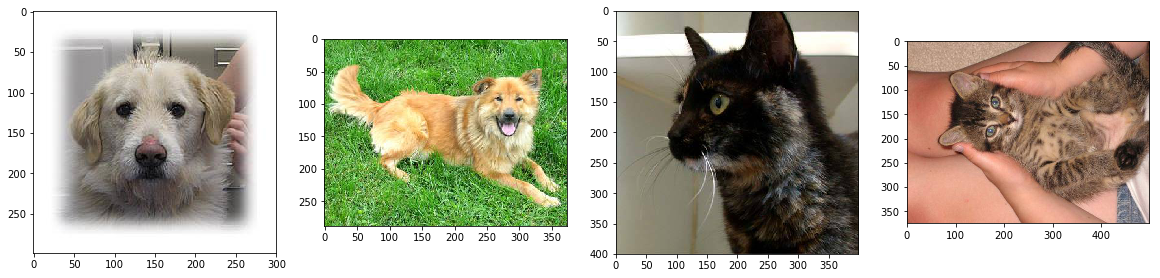

In [35]:
%matplotlib inline
import matplotlib.pyplot as plt
import skimage.io

fig = plt.figure(figsize=(20, 10))

for i, example in enumerate(examples):
    a = fig.add_subplot(1,len(examples), i+1)
    plt.imshow(skimage.io.imread(test_dataset_dir + example + '.jpg'))
    # a.set_title(codes[examples[0]])

# Create predictions for test images

In [36]:
import numpy as np
import tensorflow as tf

from tensorflow.python.saved_model import loader
from tensorflow.python.saved_model.tag_constants import SERVING

tf.reset_default_graph()

# target_model_path = model_path
#target_model_path = "{}/test2/".format(model_path)
target_model_path = "{}test2/".format(model_path)

with tf.device(default_device):
    with tf.Session(graph=tf.Graph()) as sess:
        
        loader.load(sess, [SERVING], target_model_path)

        with open('out5.csv', 'w') as f:
            f.write('id,label\n')

            for b_images, b_keys in get_batches(images, keys):
                s_keep_probability = sess.graph.get_tensor_by_name('inputs/keep_probability:0')
                s_images = sess.graph.get_tensor_by_name('inputs/images:0')
                s_is_training = sess.graph.get_tensor_by_name('inputs/is_training:0')
                s_predictions = sess.graph.get_tensor_by_name('outputs/predictions:0')

                preds = sess.run(s_predictions, feed_dict={
                    s_images: b_images,
                    s_keep_probability: 1.,
                    s_is_training: False
                })

                for idx,pred in enumerate(preds):
                    s = '{},{:.5f}\n'.format(b_keys[idx], np.clip(pred[0], 0.05, 0.95))
                    f.write(s)